# Learning how to build RNNs for NLP
## Based on Chap 16 of Hands on ML 3rd ed

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(0)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial# Learning how to build RNNs for sequential data
## Based on Chap 15 of Hands on ML 3rd ed
### The title may have been a lie because there will be CNNs too

## Char-RNNs to predict the next character in a sentence

### Split sequence into batches of shuffled windows
For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,[0, 1, 2, 3, 4], [2, 3, 4, 5, 6], etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., [2, 3, 4, 5, 6] would be split into [[2, 3, 4, 5], [3, 4, 5, 6]]), then create batches of 3 such input/target pairs:

In [2]:

np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### Load and prepare the dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
len(shakespeare_text)

1115394

In [6]:
# List of all characters in the text
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [7]:
# Tokenize using keras tokenizer to turn letters into numbers. converts to lowercase by default but can turn that off using lower=False argument
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [8]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [9]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [10]:
# Get stats
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

### Encoding and splitting the dataset

In [11]:
# Encoding the dataset
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
# Different way of splitting, can't just shuffle all the characters
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [12]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [13]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [16]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [17]:
dataset = dataset.prefetch(1)

In [18]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### Create and train model
RNN with 2 GRU layers of 128 units and 20% dropout on both inputs and hidden states.

In [19]:
# Too slow to run on laptop. Output layer is time distributed dense layer with 39 units (max_id) because 39 distinct char in text. output a probability for each char
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Train for 31370 steps
Epoch 1/10
  466/31370 [..............................] - ETA: 2:18:00 - loss: 2.5551

KeyboardInterrupt: 

### Use the model to generate text

In [20]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [25]:
# This would output 'u' as the last character from the model
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

### Generate fake text
1. Could feed some text and use the model to predict the most likely next letter, add it to the end of the text, and use it predict again - often leads to same words being repeated
2. Pick the next character randomly with probability equal to estimated probability. Generates more interesting and diverse text.

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]],
      dtype=int64)

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [26]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [27]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

tirst on the the me the come the the the what the s


In [ ]:
print(complete_text("t", temperature=1))

In [ ]:
# Low temperature favors the high probability characters while high ones give all equal probability
print(complete_text("t", temperature=2))

To improve model - add more GRU layers and more neurons per layer, train for longer, add some regularization (eg dropout in GRU layers)

## Stateful RNNs
Preserve final state after processing one batch, use as initial state for next training batch. Only makes sense if each input sequence in batch starts exactly where corresponding sequence in previous batch left off. Need to use sequential and non-overlapping input sequences. Batching much harder, use batches containing only a single window

In [28]:
tf.random.set_seed(42)

In [29]:
# remember window_length = n_steps+1. Don't want overlap
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [30]:
# For batching, chop Shakespeares text into 32 texts of equal length, create one dataset of consecutive input sequences for each one, and finally use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
# creates proper consecutive batches
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [31]:
model = keras.models.Sequential([
    # mention stateful = True on each recurrent layer, also needs to know the batch size
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
# At end of each epoch reset the states before we go back to the beginning of the text (otherwise will retain with stateful arg)
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
# Giving me nan loss, come back later
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Train for 313 steps
Epoch 1/50
313/313 [==============================] - 81s 259ms/step - loss: nan
Epoch 2/50
313/313 [==============================] - 74s 236ms/step - loss: nan
Epoch 3/50
313/313 [==============================] - 71s 228ms/step - loss: nan
Epoch 4/50
313/313 [==============================] - 70s 223ms/step - loss: nan
Epoch 5/50
313/313 [==============================] - 67s 213ms/step - loss: nan
Epoch 6/50
313/313 [==============================] - 67s 213ms/step - loss: nan
Epoch 7/50
  4/313 [..............................] - ETA: 1:09 - loss: nan

KeyboardInterrupt: 

## Sentiment Analysis
1. Look at word level models
2. IMDB reviews dataset is like the "hello world" of NLP. 50k movie reviews (25k for training, 25k for testing) - binary target negative (0) or positive (1).

In [34]:
tf.random.set_seed(42)

In [35]:

(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


In [36]:
# already tokenized
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [37]:
# to get back text
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

To deploy model to mobile device or web browser, and don't want to write different preprocessing function each time, handle preprocessing using only Tensorflow operations, so it can be included in the model

In [38]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to C:\Users\Aditya (Work)\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteQR7IH6\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\Aditya (Work)\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteQR7IH6\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\Aditya (Work)\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteQR7IH6\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\Aditya (Work)\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [39]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [40]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [41]:
train_size, test_size

(25000, 25000)

In [42]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This is a big step down after the surprisingly enjoyable original. This sequel isn't nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best ...
Label: 0 = Negative

Review: Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian schoo ...
Label: 0 = Negative



In [43]:
# Preprocessing function using only tf
def preprocess(X_batch, y_batch):
    # Truncate to keep only first 300 characters (can usually tell if review positive or not in first few sentences)
    X_batch = tf.strings.substr(X_batch, 0, 300)
    # Replace <br > tags with spaces
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    # Replace any character apart from letters and quotes with spaces
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    # Split by spaces to get ragged tensor
    X_batch = tf.strings.split(X_batch)
    # Converts to dense tensor by padding all reviews to same length
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [44]:
preprocess(X_batch, y_batch)

(<tf.Tensor: id=42307, shape=(2, 60), dtype=string, numpy=
 array([[b'This', b'is', b'a', b'big', b'step', b'down', b'after', b'the',
         b'surprisingly', b'enjoyable', b'original', b'This', b'sequel',
         b"isn't", b'nearly', b'as', b'fun', b'as', b'part', b'one',
         b'and', b'it', b'instead', b'spends', b'too', b'much', b'time',
         b'on', b'plot', b'development', b'Tim', b'Thomerson', b'is',
         b'still', b'the', b'best', b'thing', b'about', b'this',
         b'series', b'but', b'his', b'wisecracking', b'is', b'toned',
         b'down', b'in', b'this', b'entry', b'The', b'performances',
         b'are', b'all', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>'],
        [b'Perhaps', b'because', b'I', b'was', b'so', b'young',
         b'innocent', b'and', b'BRAINWASHED', b'when', b'I', b'saw',
         b'it', b'this', b'movie', b'was', b'the', b'cause', b'of',
         b'many', b'sleepless', b'nights', b'for', b'me', b'I',
       

In [45]:
# Construct the vocabulary. Go through entire training set once, apply preprocess and count occurences of each word
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [46]:
vocabulary.most_common()[:3]

[(b'<pad>', 214741), (b'the', 61137), (b'a', 38564)]

In [47]:
len(vocabulary)

53893

In [48]:
# truncate to keep only 10k most common
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [49]:
# last word not found so mapped to one of the oov buckets with ID >= 10k
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [50]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [51]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: id=144012, shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [52]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [53]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[   22     7     2 ...     0     0     0]
 [ 1239    82     6 ...   418    28  4245]
 [ 4246     3     1 ...     0     0     0]
 ...
 [   22     7    23 ...     0     0     0]
 [ 1297  3744     7 ...     0     0     0]
 [10928 10687  4537 ...     0     0     0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1], shape=(32,), dtype=int64)


In [54]:
embed_size = 128
model = keras.models.Sequential([
    # Embedding layer to convert word IDs into embeddings (one row per word ID) and one column per embedding dimension (tunable)
    # Inputs are 2D tensors (batch size, steps), output is 3D (batch size, steps, embedding size)
    # mask_zero=True will tell the model to ignore the padding tokens (0)
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 113s 144ms/step - loss: 0.5381 - accuracy: 0.7222
Epoch 2/5
781/781 [==============================] - 109s 140ms/step - loss: 0.3526 - accuracy: 0.8548
Epoch 3/5
781/781 [==============================] - 102s 130ms/step - loss: 0.2025 - accuracy: 0.9278
Epoch 4/5
781/781 [==============================] - 101s 129ms/step - loss: 0.1257 - accuracy: 0.9574
Epoch 5/5
781/781 [==============================] - 104s 133ms/step - loss: 0.0997 - accuracy: 0.9660


In [ ]:
### Masking manually, in case need to combine conv1D layers with RNN
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

## Reusing pretrained embeddings 
1. Tensorflow hub project has modules to use. Copy code example into project, module will be downloaded along with pretrained weights and included in model. (Note that not all modules support TF2)
2. This particular one takes strings as input and encodes each one as single vector (50 dimensional). Embeds each word using an embedding matrix that was trained on a huge corpus (google news 7B). Can add 2 dense layers to create a good sentiment analysis model. Can set trainable=True to fine tune hub models.

In [55]:
tf.random.set_seed(42)

In [61]:
# Setting TFHUB cache
TFHUB_CACHE_DIR = "../data/my_tfhub_cache"
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [62]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [63]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

../data/my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
../data/my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\saved_model.pb
../data/my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\assets\tokens.txt
../data/my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.data-00000-of-00001
../data/my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.index


In [64]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 107s 137ms/step - loss: 0.5499 - accuracy: 0.7213
Epoch 2/5
781/781 [==============================] - 109s 139ms/step - loss: 0.5143 - accuracy: 0.7484
Epoch 3/5
781/781 [==============================] - 105s 135ms/step - loss: 0.5091 - accuracy: 0.7514
Epoch 4/5
781/781 [==============================] - 104s 133ms/step - loss: 0.5058 - accuracy: 0.7543
Epoch 5/5
781/781 [==============================] - 105s 134ms/step - loss: 0.5029 - accuracy: 0.7567


## Neural Machine Translation

In [2]:
tf.random.set_seed(42)
vocab_size = 100
embed_size = 10

In [6]:
# tensorflow_addons has an issue with tf 2.0.0 (runs on 2.1.0 and above. Fix later)

import tensorflow_addons as tfa # contains several seq-to-seq tools to easily build encoder-decoders

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

# Set return state True to get final hidden state and pass to decoder. 2 hidden states, short term and long term
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# One of several samplers. Tells the decoders at each step what to pretend the previous output was.
# During inference, should be the embedding of the token actually output, during training embedding of previous target token
sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

AttributeError: module 'tensorflow_core.keras.utils' has no attribute 'register_keras_serializable'

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

### Bidirectional RNNs
Regular RNN only looks at past and present inputs (causal). Makes sense for time series but for many NLP tasks like NMT, prefered to look ahead at next words. Run 2 RNNs, one left to right one right to left. Combine outputs at each time step, typically by concatenation.

In [7]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Attention mechanisms

### Positional Encoding

In [9]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [10]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

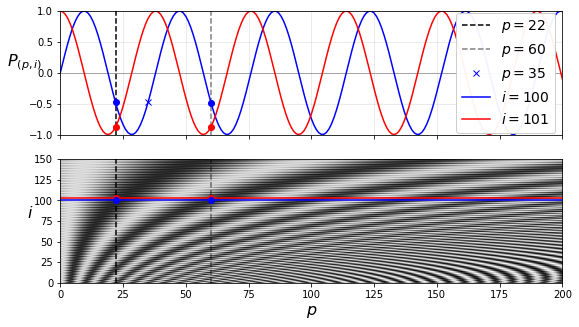

In [11]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [12]:
# first layer of the transformer
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

### Simplified transformer architecture 

In [13]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    # Attention layer implements scaled dot product attention
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

### Multi head attention

In [15]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [16]:

Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

### Recent innovations
1. ELMo - Embeddings from language models
2. GPT - stack of 12 transformer modules
3. BERT - Bidirectional Endoder Representations from Transformers - similar architecture to GPT, but non-masked multi-head attention layers. 2 pretraining tasks - masked language model (MLM), next sentence prediction (NSP)
4. Main innovations in better subword tokenization, shifting from LSTM to transformer